In [ ]:
import torch
device = torch.device("cuda")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data/drugsComTrain_raw.tsv", sep = '\t')
test = train = pd.read_csv("/content/drive/MyDrive/data/drugsComTest_raw.tsv", sep = '\t')
train

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [ ]:
def tokenizer(sent):
    tokenizer_initial = TreebankWordTokenizer()
    return tokenizer_initial.tokenize(sent)

def rm_stopword(tok):
    stop = stopwords.words('english')
    return [i for i in tok if i not in stop]

def stem(tok):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(i) for i in tok])

def preprocess(data):
    # Converting to lowercase
    data['review_clean'] = data['review'].str.lower()

    # Remove links
    data['review_clean'] = data['review_clean'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

    # Remove punctuations
    data['review_clean'] = data['review_clean'].str.replace('[^\w\s]','')

    # Remove Numbers
    data['review_clean'] = data['review_clean'].str.replace('\d+', '')

    # Tokenizing
    data['review_clean'] = data['review_clean'].apply(str).apply(lambda x: tokenizer(x))

    # Remove stopwords
    data['review_clean'] = data['review_clean'].apply(lambda x: rm_stopword(x))

    # Stemming
    data['review_clean'] = data['review_clean'].apply(lambda x: stem(x))

    return data

In [ ]:
df = preprocess(train)
# df_test = preprocess(test)
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_clean
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22,ive tri antidepress year citalopram fluoxetin ...
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17,son crohn diseas done well asacol complaint sh...
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3,quick reduct symptom
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,contrav combin drug use alcohol smoke opioid c...
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4,birth control one cycl read review type simila...
...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43,taken tamoxifen year side effect sever sweat d...
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11,ive take lexapro escitaploprgram sinc februari...
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7,im marri year old kid take pill hassl decid ge...
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20,prescrib nucynta sever neckshould pain take mg...


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_clean'])

X = df['review_clean']
y = df['rating'].astype(int)
y_prime = y.apply(lambda x: x-1)
y_cat = to_categorical(y_prime)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, stratify = y_cat, test_size = 0.2, random_state = 42)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_len = 25
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-03 04:41:05--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.117
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  62.7MB/s    in 25s     

2021-12-03 04:41:31 (61.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

In [ ]:
word_vectors.similarity('woman', 'girl')

0.7494641

In [ ]:
embedding_dim = 300
# unique_vocab = len(tokenizer.word_index)
unique_vocab = 150000
embedding_matrix = np.zeros((unique_vocab + 1, embedding_dim))

for word, i in tokenizer.word_index.items():      
    if word in word_vectors.vocab:
        embedding_matrix[i] = word_vectors[word]

In [ ]:
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 140469


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout1D
import keras

model = Sequential()
model.add(Embedding(input_dim = unique_vocab + 1, output_dim = embedding_dim, input_length = max_len,
                    weights = [embedding_matrix], trainable = False))

model.add(Conv1D(300, 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(300, 5, padding ='same', activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(300, 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(300, 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.to(device)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 300)           45000300  
                                                                 
 conv1d_12 (Conv1D)          (None, 25, 300)           450300    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 12, 300)          0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 12, 300)          1200      
 chNormalization)                                                
                                                                 
 spatial_dropout1d_12 (Spati  (None, 12, 300)          0         
 alDropout1D)                                                    
                                                      

In [ ]:
history = model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 100)

Epoch 1/50
1345/1345 [==============================] - 208s 153ms/step - loss: 1.9591 - accuracy: 0.3290 - val_loss: 1.8926 - val_accuracy: 0.3430
Epoch 2/50
1345/1345 [==============================] - 209s 155ms/step - loss: 1.8553 - accuracy: 0.3595 - val_loss: 1.8302 - val_accuracy: 0.3643
Epoch 3/50
1345/1345 [==============================] - 208s 154ms/step - loss: 1.8142 - accuracy: 0.3693 - val_loss: 1.8068 - val_accuracy: 0.3664
Epoch 4/50
1345/1345 [==============================] - 203s 151ms/step - loss: 1.7727 - accuracy: 0.3788 - val_loss: 1.7842 - val_accuracy: 0.3749
Epoch 5/50
1345/1345 [==============================] - 201s 149ms/step - loss: 1.7352 - accuracy: 0.3904 - val_loss: 1.7723 - val_accuracy: 0.3846
Epoch 6/50
1345/1345 [==============================] - 203s 151ms/step - loss: 1.6985 - accuracy: 0.4005 - val_loss: 1.7510 - val_accuracy: 0.3839
Epoch 7/50
1345/1345 [==============================] - 204s 152ms/step - loss: 1.6555 - accuracy: 0.4096 - val_

In [ ]:
# from lightgbm import LGBMModel,LGBMClassifier, plot_importance

# clf = LGBMClassifier(n_estimators=10000, learning_rate=0.1, verbose = 5)
# model1 = clf.fit(X_train, y_train)

In [ ]:
# y_pred = model.predict(X_test)

# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot = True, fmt = 'g')

In [ ]:
model.save("/content/drive/MyDrive/data/drug_review_model4.h5")
# model1.booster_.save_model("/content/drive/MyDrive/data/drug_review_model.h5")

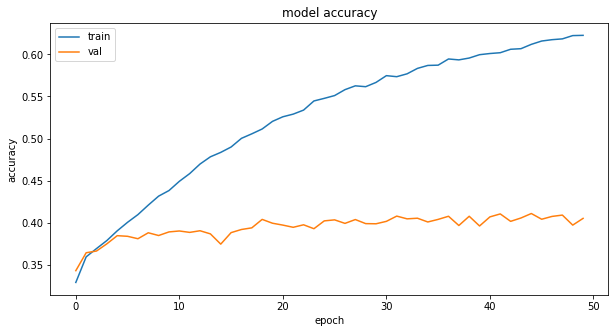

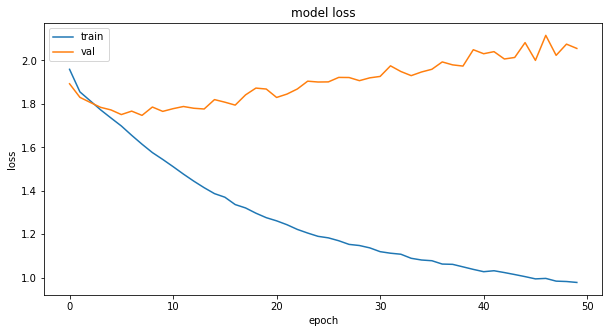

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc = 'best')
plt.xlabel('epoch');
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'best')
plt.xlabel('epoch');
plt.show()

In [ ]:
# from gensim.models import Word2Vec

# def build_model(data):
#     review = data['review_clean'].values
#     review = list(review)
#     review.append(['pad'])

#     model = Word2Vec(review, workers = -1, min_count = 1, window = 5, sg = 0, size = 500)
#     model.save("/content/drive/MyDrive/data/word2vec.model")
#     return model

In [ ]:
# model = build_model(df)

In [ ]:
# max_sen_len = df['review_clean'].map(len).max()

# padding_idx = w2vmodel.wv.vocab['pad'].index

# def make_word2vec_vector_cnn(sentence):
#     padded_X = [padding_idx for i in range(max_sen_len)]
#     i = 0
#     for word in sentence:
#         if word not in w2vmodel.wv.vocab:
#             padded_X[i] = 0
#         else:
#             padded_X[i] = w2vmodel.wv.vocab[word].index
#         i += 1
#     return padded_X

In [ ]:
# m1 -> 60
# m2 -> 67
# m3 -> 